# Clasification

## MNIST dataset

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


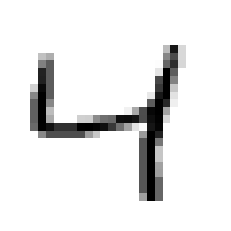

In [3]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt


idx = 2
some_digit = X[idx]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [4]:
y[idx]

'4'

In [5]:
import numpy as np
y = y.astype(np.uint8)

In [6]:
split_idx = 60_000
X_train, X_test, y_train, y_test = X[:split_idx], X[split_idx:], y[:split_idx], y[split_idx:]

## Binary classifier

In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [9]:
sgd_clf.predict([some_digit])

array([False])

## Performance measurement

### Cross-validation

In [10]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.0s finished


array([0.95035, 0.96035, 0.9604 ])

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished


array([0.91125, 0.90855, 0.90915])

### Confusion matrix

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, verbose=2, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.5s finished


In [15]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

### Precision and recall

In [16]:
from sklearn.metrics import precision_score, recall_score
print('Precision: ', precision_score(y_train_5, y_train_pred))
print('Recall:    ', recall_score(y_train_5, y_train_pred))

Precision:  0.8370879772350012
Recall:     0.6511713705958311


In [17]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [18]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function', 
                             n_jobs=-1, verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.7s finished


In [19]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [20]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.grid(True)
    plt.xlabel('Threshold')
    plt.xlim((-50_000, 45_000))

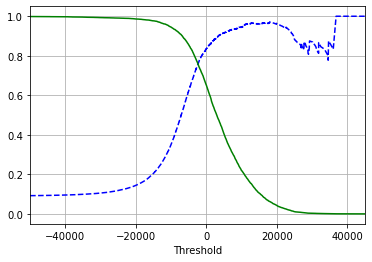

In [21]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [22]:
thresholds_90_precision = thresholds[np.argmax(precisions >= 0.90)]
thresholds_90_precision

3370.0194991439557

In [23]:
y_train_pred_90 = (y_scores > thresholds_90_precision)
print('Precision: ',precision_score(y_train_5, y_train_pred_90))
print('Recall:    ',recall_score(y_train_5, y_train_pred_90))

Precision:  0.9
Recall:     0.47980077476480354


### ROC curve

In [24]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

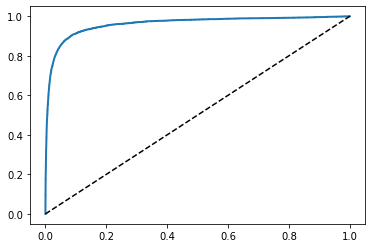

In [25]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    
    
plot_roc_curve(fpr, tpr)
plt.show()

In [26]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [27]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_proba_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                  method='predict_proba',
                                  n_jobs=-1, verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.6s finished


In [28]:
y_scores_forest = y_proba_forest[:, 1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

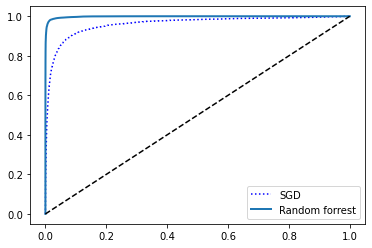

In [29]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random forrest')
plt.legend(loc='lower right')
plt.show()

In [30]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145